# ATLAS Open Data H>ZZ* with ServiceX, coffea, cabinetry & pyhf

In [1]:
import asyncio
import os
import re
import time

import cabinetry
from coffea.processor import servicex
from func_adl import ObjectStream
from func_adl_servicex import ServiceXSourceUpROOT
import hist
import matplotlib.pyplot as plt
import numpy as np
from servicex.servicex import ServiceXDataset
import uproot

import utils
from utils import infofile  # contains cross-section information

utils.clean_up()  # delete output from previous runs of notebook (optional)
utils.set_logging()

to-do:

    - metadata handling in processor

## Introduction

We are going to use the ATLAS Open Data for this demonstration, in particular a H>ZZ* analysis. Find more information on the [ATLAS Open Data documentation](http://opendata.atlas.cern/release/2020/documentation/physics/FL2.html) and in [ATL-OREACH-PUB-2020-001](https://cds.cern.ch/record/2707171). The datasets used are [10.7483/OPENDATA.ATLAS.2Y1T.TLGL](http://doi.org/10.7483/OPENDATA.ATLAS.2Y1T.TLGL). The material in this notebook is based on the [ATLAS Open Data notebooks](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata), a [PyHEP 2021 ServiceX demo](https://github.com/gordonwatts/pyhep-2021-SX-OpenDataDemo), and [Storm Lin's adoption](https://github.com/stormsomething/CoffeaHZZAnalysis) of this analysis.

This notebook is meant as a **technical demonstration**. In particular, the systematic uncertainties defined are purely to demonstrate aspects of realistic workflows, and are not meant to be meaningful physically. The fit performed to data consequently also only demonstrate technical aspects. If you are interested about the physics of H>ZZ*, check out for example the actual ATLAS cross-section measurement: [Eur. Phys. J. C 80 (2020) 942](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/HIGG-2018-29/).

In [2]:
prefix = (
    "root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2020-01-22/4lep/"
)

fileset = {
    "Data": [
        prefix + "Data/data_A.4lep.root",
        prefix + "Data/data_B.4lep.root",
        prefix + "Data/data_C.4lep.root",
        prefix + "Data/data_D.4lep.root",
    ],
    "Background $Z,tt^{bar}$": [
        prefix + "MC/mc_361106.Zee.4lep.root",
        prefix + "MC/mc_361107.Zmumu.4lep.root",
        prefix + "MC/mc_410000.ttbar_lep.4lep.root",
    ],
    "Background $ZZ^{star}$": [prefix + "MC/mc_363490.llll.4lep.root"],
    "Signal ($m_H$ = 125 GeV)": [
        prefix + "MC/mc_345060.ggH125_ZZ4lep.4lep.root",
        prefix + "MC/mc_344235.VBFH125_ZZ4lep.4lep.root",
        prefix + "MC/mc_341964.WH125_ZZ4lep.4lep.root",
        prefix + "MC/mc_341947.ZH125_ZZ4lep.4lep.root",
    ],
}

## Setting up a query with `func_adl`

`func_adl` for lepton selection, and the datasource is provided for a given query (which will be given by `good_leptons`).

**systematic uncertainty**: scale factor variation, applied already at event selection stage. Imagine that this could be a calculation that requires a lot of different variables which are no longer needed downstream afterwards, so it makes sense to do it here.

In [3]:
def good_leptons(source: ObjectStream) -> ObjectStream:
    """Select out all good leptons from each event. Return their pt, eta, phi, and E, and other
    things needed downstream.

    Because uproot doesn't tie together the objects, we can't do any cuts at this point.
    """
    return source.Select(
        lambda e: {
            "lep_pt": e.lep_pt,
            "lep_eta": e.lep_eta,
            "lep_phi": e.lep_phi,
            "lep_energy": e.lep_E,
            "lep_charge": e.lep_charge,
            "lep_typeid": e.lep_type,
            "mcWeight": e.mcWeight,
            "scaleFactor": e.scaleFactor_ELE
            * e.scaleFactor_MUON
            * e.scaleFactor_LepTRIGGER
            * e.scaleFactor_PILEUP,
            # scale factor systematic variation example
            "scaleFactorUP": e.scaleFactor_ELE
            * e.scaleFactor_MUON
            * e.scaleFactor_LepTRIGGER
            * e.scaleFactor_PILEUP
            * 1.2,
            "scaleFactorDOWN": e.scaleFactor_ELE
            * e.scaleFactor_MUON
            * e.scaleFactor_LepTRIGGER
            * e.scaleFactor_PILEUP
            * 0.8,
        }
    )


def make_datasource(name: str, query: ObjectStream):
    """Create a ServiceX Datasource for a particular ATLAS Open data file"""
    datasets = [ServiceXDataset(fileset[name], backend_name="uproot")]
    return servicex.DataSource(
        query=query, metadata={"dataset": name}, datasets=datasets
    )

## Processing `ServiceX`-provided data with `coffea`

Event weighting: look up cross-section from a provided utility file, and correctly normalize all events.

In [4]:
def get_xsec_weight(sample):
    lumi = 10_000  # pb^-1 for data_A, data_B, data_C, data_D
    xsec_map = infofile.infos[sample]  # dictionary with event weighting information
    xsec_weight = (lumi * xsec_map["xsec"]) / (
        xsec_map["sumw"] * xsec_map["red_eff"]
    )  # *1000 to go from fb-1 to pb-1
    return xsec_weight  # return cross-section weight

Cuts to apply:
- two opposite flavor leptons (total lepton charge is 0)
- lepton types: 4 electrons, 4 muons, or 2 electrons + 2 muons

In [5]:
def cut_lep_charge(lep_charge):
    # lepton charge sum should be 0
    return (
        lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3]
    ) == 0


def cut_lep_type(lep_type):
    # for an electron, lep_type is 11, and for a muon it is 13
    # keep events of type eeee, mumumumu, eemumu
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
    return (sum_lep_type == 44) | (sum_lep_type == 48) | (sum_lep_type == 52)

Set up the `coffea` processor. It will apply cuts, calculate the four-lepton invariant mass, and fill a histogram.

**systematic uncertainty**: m4l variation, applied in the processor to remaining events. This might for example be the result of applying a tool performing a computationally expensive calculation, which should only be run for events where it is needed.

In [6]:
class HZZAnalysis(servicex.Analysis):
    def process(self, events):
        # Get dataset name and lepton information from events
        dataset = events.metadata["dataset"]
        leptons = events.lep

        # Cut events based on lepton charge, then update leptons
        events = events[cut_lep_charge(leptons.charge)]
        leptons = events.lep

        # Cut events based on lepton type, then update leptons
        events = events[cut_lep_type(leptons.typeid)]
        leptons = events.lep

        # Calculate the mllll for each event
        mllll = (
            leptons[:, 0] + leptons[:, 1] + leptons[:, 2] + leptons[:, 3]
        ).mass / 1000

        # histogram holding outputs, with two axes: m4l bins and category (data or various process simulations)
        mllllhist_data = hist.Hist.new.Reg(
            34, 80, 250, name="mllll", label="$\mathrm{m_{4l}}$ [GeV]"
        ).Weight()

        mllllhist_MC = (
            hist.Hist.new.Reg(
                34, 80, 250, name="mllll", label="$\mathrm{m_{4l}}$ [GeV]"
            )
            .StrCat(
                [
                    "Background $Z,tt^{bar}$",
                    "Background $ZZ^{star}$",
                    "Signal ($m_H$ = 125 GeV)",
                ],
                name="dataset",
            )
            .StrCat(
                ["nominal", "scaleFactorUP", "scaleFactorDOWN", "m4lUP", "m4lDOWN"],
                name="variation",
            )
            .Weight()
        )

        if "data_A" in dataset:
            # Create and fill a histogram for mllll
            mllllhist_data.fill(mllll=mllll)

        else:
            # Extract the sample name from the filename metadata with regex
            sample = re.findall(r"mc_\d+\.(.+)\.4lep", events.metadata["filename"])[0]

            # Calculate the event weights
            basic_weight = get_xsec_weight(sample) * events.mcWeight
            totalWeights = basic_weight * events.scaleFactor
            totalWeightsUp = basic_weight * events.scaleFactorUP
            totalWeightsDown = basic_weight * events.scaleFactorDOWN

            if sample in ["ttbar_lep", "Zee", "Zmumu"]:
                dataset = "Background $Z,tt^{bar}$"
            elif sample == "llll":
                dataset = "Background $ZZ^{star}$"
            elif sample in [
                "ggH125_ZZ4lep",
                "VBFH125_ZZ4lep",
                "WH125_ZZ4lep",
                "ZH125_ZZ4lep",
            ]:
                dataset = "Signal ($m_H$ = 125 GeV)"

            # Create and fill a weighted histogram for mllll
            mllllhist_MC.fill(
                mllll=mllll, dataset=dataset, variation="nominal", weight=totalWeights
            )

            mllllhist_MC.fill(
                mllll=mllll,
                dataset=dataset,
                variation="scaleFactorUP",
                weight=totalWeightsUp,
            )
            mllllhist_MC.fill(
                mllll=mllll,
                dataset=dataset,
                variation="scaleFactorDOWN",
                weight=totalWeightsDown,
            )

            mllllhist_MC.fill(
                mllll=mllll * 1.1,
                dataset=dataset,
                variation="m4lUP",
                weight=totalWeights,
            )
            mllllhist_MC.fill(
                mllll=mllll * 0.9,
                dataset=dataset,
                variation="m4lDOWN",
                weight=totalWeights,
            )

        return {"data": mllllhist_data, "MC": mllllhist_MC}

## Producing the desired histograms

Define a function performing event selection and histogram accumulation.

In [7]:
async def produce_all_histograms():
    """Run on a known analysis file/files and return the result.
    Should be fine to start many of these at once.
    """
    # Create the query
    ds = ServiceXSourceUpROOT("cernopendata://dummy", "mini", backend_name="uproot")
    ds.return_qastle = True
    lepton_query = good_leptons(ds)

    if os.environ.get("LABEXTENTION_FACTORY_MODULE") == "coffea_casa":
        # use DaskExecutor on coffea-casa
        executor = servicex.DaskExecutor(client_addr="tls://localhost:8786")
    else:
        executor = servicex.LocalExecutor()

    datasources = [make_datasource(ds_name, lepton_query) for ds_name in fileset.keys()]

    # Create the analysis processor
    analysis_processor = HZZAnalysis()

    async def run_updates_stream(accumulator_stream, name):
        """Run to get the last item in the stream"""
        coffea_info = None
        try:
            async for coffea_info in accumulator_stream:
                pass
        except Exception as e:
            raise Exception(f"Failure while processing {name}") from e
        return coffea_info

    all_histogram_dicts = await asyncio.gather(
        *[
            run_updates_stream(
                executor.execute(analysis_processor, source), source.metadata["dataset"]
            )
            for source in datasources
        ]
    )
    full_data_histogram = sum([h["data"] for h in all_histogram_dicts])
    full_mc_histogram = sum([h["MC"] for h in all_histogram_dicts])

    return {"data": full_data_histogram, "MC": full_mc_histogram}

Now run the function just defined: obtain data from ServiceX, run processor, gather output histogram.

In [8]:
t0 = time.time()

# in a notebook:
output = await produce_all_histograms()

# as a script:
# async def produce_all_the_histograms():
#    return await produce_all_histograms()
#
# output = asyncio.run(produce_all_the_histograms())

print(f"execution took {time.time() - t0:.2f} seconds")

execution took 2.92 seconds


## Plotting with `hist` and `mplhep`

Plotting with `mplhep` via `hist` happens next.

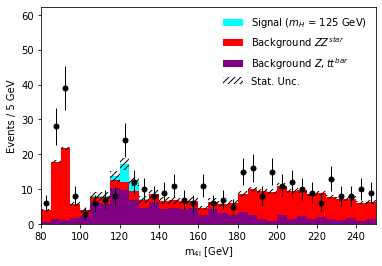

In [9]:
# Plot the histograms
hist.Hist.plot1d(output["data"], histtype="errorbar", color="black")
hist.Hist.plot1d(
    output["MC"][:, :, "nominal"],
    stack=True,
    histtype="fill",
    color=["purple", "red", "cyan"],
)

# Basic bin parameters
xmin = 80
xmax = 250
step_size = 5

bin_centers = np.arange(
    start=xmin + step_size / 2,  # The interval includes this value
    stop=xmax + step_size / 2,  # The interval doesn't include this value
    step=step_size,
)  # Spacing between values

# or via bin_centers = output["Data"].axes[0].centers

# Calculate background statistical uncertainty
mc_histogram_sum = output["MC"][:, :, "nominal"].project("mllll").values()
mc_err = np.sqrt(output["MC"][:, :, "nominal"].project("mllll").variances())

# Plot background statistical uncertainty
plt.bar(
    bin_centers,  # x
    2 * mc_err,  # heights
    alpha=0.5,  # half transparency
    bottom=mc_histogram_sum - mc_err,
    color="none",
    hatch="////",
    width=step_size,
    label="Stat. Unc.",
)

# Tune plot appearance
main_axes = plt.gca()
main_axes.set_xlim(left=xmin, right=xmax)
main_axes.set_ylim(bottom=0, top=np.amax(output["data"].values()) * 1.6)
main_axes.set_ylabel("Events / " + str(step_size) + " GeV")
main_axes.legend(frameon=False);

## Saving histograms with uproot

In [10]:
file_name = "histograms.root"
with uproot.recreate(file_name) as f:
    f["data"] = output["data"]

    f["Z_tt"] = output["MC"][:, "Background $Z,tt^{bar}$", "nominal"]
    f["Z_tt_SF_up"] = output["MC"][:, "Background $Z,tt^{bar}$", "scaleFactorUP"]
    f["Z_tt_SF_down"] = output["MC"][:, "Background $Z,tt^{bar}$", "scaleFactorDOWN"]
    f["Z_tt_m4l_up"] = output["MC"][:, "Background $Z,tt^{bar}$", "m4lUP"]
    f["Z_tt_m4l_down"] = output["MC"][:, "Background $Z,tt^{bar}$", "m4lDOWN"]

    f["ZZ"] = output["MC"][:, "Background $ZZ^{star}$", "nominal"]
    f["ZZ_SF_up"] = output["MC"][:, "Background $ZZ^{star}$", "scaleFactorUP"]
    f["ZZ_SF_down"] = output["MC"][:, "Background $ZZ^{star}$", "scaleFactorDOWN"]
    f["ZZ_m4l_up"] = output["MC"][:, "Background $ZZ^{star}$", "m4lUP"]
    f["ZZ_m4l_down"] = output["MC"][:, "Background $ZZ^{star}$", "m4lDOWN"]

    f["signal"] = output["MC"][:, "Signal ($m_H$ = 125 GeV)", "nominal"]
    f["signal_SF_up"] = output["MC"][:, "Signal ($m_H$ = 125 GeV)", "scaleFactorUP"]
    f["signal_SF_down"] = output["MC"][:, "Signal ($m_H$ = 125 GeV)", "scaleFactorDOWN"]
    f["signal_m4l_up"] = output["MC"][:, "Signal ($m_H$ = 125 GeV)", "m4lUP"]
    f["signal_m4l_down"] = output["MC"][:, "Signal ($m_H$ = 125 GeV)", "m4lDOWN"]

## Building a workspace and running a fit with cabinetry / pyhf

**systematic uncertainty**: ZZ normalization, not requiring any histograms

In [11]:
config = cabinetry.configuration.load("config.yml")
cabinetry.templates.collect(config)
cabinetry.templates.postprocess(config)
ws = cabinetry.workspace.build(config)

INFO - cabinetry.configuration - opening config file config.yml
INFO - cabinetry.workspace - building workspace


Create a `pyhf` model and extract the data from the workspace. Perform a MLE fit, and produce the post-fit model prediction.

In [12]:
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)
postfit_model = cabinetry.model_utils.prediction(model, fit_results=fit_results)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - MINUIT status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 80.28                      │             Nfcn = 2331              │
│ EDM = 1.67e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

Finally, visualize the post-fit model and data. This is done using information stored in the workspace, which does not include binning or which observable is used. This information can be passed in via the `config` kwarg, but we can also edit the figure after its creation. We will demonstrate both below.

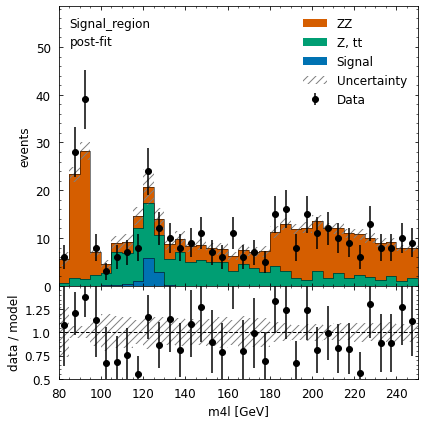

In [13]:
# binning to use in plot
plot_config = {"Regions": [{"Name": "Signal_region", "Binning": list(np.linspace(80, 250, 35))}]}

figure_dict = cabinetry.visualize.data_mc(postfit_model, data, config=plot_config, close_figure=True)

# modify x-axis label
figure_dict[0]["figure"].axes[1].set_xlabel("m4l [GeV]")

# show the modified figure
figure_dict[0]["figure"]